## Imports

In [7]:
import pickle
import random
import os
from collections import Counter

import nltk
import pylab as plt
from PIL import Image
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.utils.data as data
from torch.nn.utils.rnn import pack_padded_sequence

## Data Processing

### Loading The Data
In this section we load the HARRISON data set which we have extracted into the data directory

In [8]:
with open("data/HARRISON/data_list.txt") as f:
    data_list = f.read().splitlines()
with open("data/HARRISON/tag_list.txt") as f:
    tag_list = f.read().splitlines()

In [9]:
print(data_list[0])
print(tag_list[0])

instagram_dataset/sea/image_50.jpg
sea instapic instagram trip travel 


### Visualizing The Data

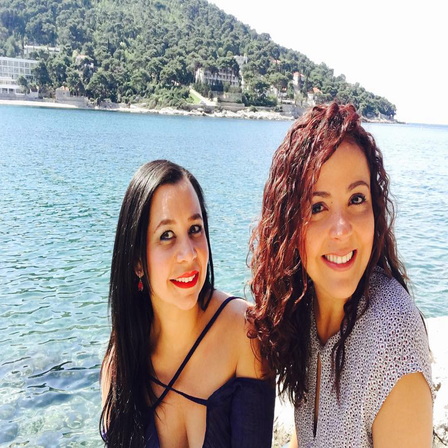

#sea, #instapic, #instagram, #trip, #travel


In [10]:
image = Image.open("data/HARRISON/" + data_list[0])
image = image.resize((448, 448), Image.ANTIALIAS)
display(image)
print("#" + ", #".join(tag_list[0].split(" "))[:-3])

### Creating A Vocabulary
A vocabulary object contains supports three main operations:
\begin{enumerate}
    \item Get the integer representation of a word
    \item Get the word representation of an integer
    \item Get the number of items in the vocabulary
\end{enumerate}
To build a vocabulary, call \textbf{build_vocabulary} and pass in a list of tagged sequences and the minimum number of times a tag must appear for it to be included in the vocabulary 

In [16]:
class Vocabulary(object):
    def __init__(self):
        self.word_to_index = {}
        self.index_to_word = []
        self.index = 0
    
    def add_word(self, word):
        if not word in self.word_to_index:
            self.word_to_index[word] = self.index
            self.index_to_word.append(word)
            self.index += 1
        else:
            raise ValueError("Word %s is already in the vocabulary!" %word)
    
    def __call__(self, word):
        if type(word) == str:
            if word not in self.word_to_index:
                raise ValueError("Word %s is not in the vocabulary!" %word)
            return self.word_to_index[word]
        elif type(word) == int:
            if self.index <= word:
                raise ValueError("Index %s is out of bounds!" %word)
            return self.index_to_word[word]
        else:
            raise ValueError("Only strings and integers are accepted inputs!")
    
    def __len__(self):
        return self.index
    
def build_vocabulary(tag_list, min_occurrences, progress_bar=True):
    counter = Counter()
    for tags in (tqdm_notebook(tag_list) if progress_bar else tag_list):
        tokens = nltk.tokenize.word_tokenize(tags.lower())
        counter.update(tokens)
        
    # a word must appear at least min_occurrence times to be included in the vocabulary
    words = [word for word, count in counter.items() if count >= min_occurrences]
    
    # Creating the vocabulary object
    vocab = Vocabulary()
    vocab.add_word('<SOS>')
    vocab.add_word('<EOS>')
    vocab.add_word('<UNK>')
    
    # Adds the words from the captions to the vocabulary
    for word in words:
        vocab.add_word(word)
    return vocab

vocabulary = build_vocabulary(tag_list=[tags for tags in tag_list], min_occurrences=5)
print(len(vocabulary))

HBox(children=(IntProgress(value=0, max=57383), HTML(value=u'')))


997


### Batching The Data